In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')  

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Clara/Clara_project'

/content/gdrive/.shortcut-targets-by-id/1LCuhJEx1bcKI44pAutrITcp5s1irRakT/Clara_project


# FAST AI APPROACH

In [4]:
#!/Brain/commands/train.sh

In [5]:
import torch
from fastai.callbacks import *
from fastai.vision import *

In [6]:
### Model Prototyping

In [7]:
def conv_block(c_in, c_out, ks, num_groups=None, **conv_kwargs):
    "A sequence of modules composed of Group Norm, ReLU and Conv3d in order"
    if not num_groups : num_groups = int(c_in/2) if c_in%2 == 0 else None
    return nn.Sequential(nn.GroupNorm(num_groups, c_in),
                         nn.ReLU(),
                         nn.Conv3d(c_in, c_out, ks, **conv_kwargs))

In [8]:
def reslike_block(nf, num_groups=None, bottle_neck:bool=False, **conv_kwargs):
    "A ResNet-like block with the GroupNorm normalization providing optional bottle-neck functionality"
    nf_inner = nf / 2 if bottle_neck else nf
    return SequentialEx(conv_block(num_groups=num_groups, c_in=nf, c_out=nf_inner, ks=3, stride=1, padding=1, **conv_kwargs),
                        conv_block(num_groups=num_groups, c_in=nf_inner, c_out=nf, ks=3, stride=1, padding=1, **conv_kwargs),
                        MergeLayer())

In [9]:
def upsize(c_in, c_out, ks=1, scale=2):
    "Reduce the number of features by 2 using Conv with kernel size 1x1x1 and double the spatial dimension using 3D trilinear upsampling"
    return nn.Sequential(nn.Conv3d(c_in, c_out, ks),
                       nn.Upsample(scale_factor=scale, mode='trilinear'))

In [10]:
def hook_debug(module, input, output):
    """
    Print out what's been hooked usually for debugging purpose
    ----------------------------------------------------------
       Example:
       Hooks(ms, hook_debug, is_forward=True, detach=False)
    
    """
    print('Hooking ' + module.__class__.__name__)
    print('output size:', output.data.size())
    return output

**Encoder** Part

In [11]:
class Encoder(nn.Module):
    "Encoder part"
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(4, 32, 3, stride=1, padding=1)         
        self.res_block1 = reslike_block(32, num_groups=8)
        self.conv_block1 = conv_block(32, 64, 3, num_groups=8, stride=2, padding=1)
        self.res_block2 = reslike_block(64, num_groups=8)
        self.conv_block2 = conv_block(64, 64, 3, num_groups=8, stride=1, padding=1)
        self.res_block3 = reslike_block(64, num_groups=8)
        self.conv_block3 = conv_block(64, 128, 3, num_groups=8, stride=2, padding=1)
        self.res_block4 = reslike_block(128, num_groups=8)
        self.conv_block4 = conv_block(128, 128, 3, num_groups=8, stride=1, padding=1)
        self.res_block5 = reslike_block(128, num_groups=8)
        self.conv_block5 = conv_block(128, 256, 3, num_groups=8, stride=2, padding=1)
        self.res_block6 = reslike_block(256, num_groups=8)
        self.conv_block6 = conv_block(256, 256, 3, num_groups=8, stride=1, padding=1)
        self.res_block7 = reslike_block(256, num_groups=8)
        self.conv_block7 = conv_block(256, 256, 3, num_groups=8, stride=1, padding=1)
        self.res_block8 = reslike_block(256, num_groups=8)
        self.conv_block8 = conv_block(256, 256, 3, num_groups=8, stride=1, padding=1)
        self.res_block9 = reslike_block(256, num_groups=8)
    
    def forward(self, x):
        x = self.conv1(x)                                           # Output size: (1, 32, 160, 192, 128)
        x = self.res_block1(x)                                      # Output size: (1, 32, 160, 192, 128)
        x = self.conv_block1(x)                                     # Output size: (1, 64, 80, 96, 64)
        x = self.res_block2(x)                                      # Output size: (1, 64, 80, 96, 64)
        x = self.conv_block2(x)                                     # Output size: (1, 64, 80, 96, 64)
        x = self.res_block3(x)                                      # Output size: (1, 64, 80, 96, 64)
        x = self.conv_block3(x)                                     # Output size: (1, 128, 40, 48, 32)
        x = self.res_block4(x)                                      # Output size: (1, 128, 40, 48, 32)
        x = self.conv_block4(x)                                     # Output size: (1, 128, 40, 48, 32)
        x = self.res_block5(x)                                      # Output size: (1, 128, 40, 48, 32)
        x = self.conv_block5(x)                                     # Output size: (1, 256, 20, 24, 16)
        x = self.res_block6(x)                                      # Output size: (1, 256, 20, 24, 16)
        x = self.conv_block6(x)                                     # Output size: (1, 256, 20, 24, 16)
        x = self.res_block7(x)                                      # Output size: (1, 256, 20, 24, 16)
        x = self.conv_block7(x)                                     # Output size: (1, 256, 20, 24, 16)
        x = self.res_block8(x)                                      # Output size: (1, 256, 20, 24, 16)
        x = self.conv_block8(x)                                     # Output size: (1, 256, 20, 24, 16)
        x = self.res_block9(x)                                      # Output size: (1, 256, 20, 24, 16)
        return x

In [12]:
'''
########## Sanity-check ############
input = torch.randn(1, 4, 160, 192, 128)
input = input.cuda()
encoder = Encoder()
encoder.cuda()
ms = [encoder.res_block1, encoder.res_block3, encoder.res_block5]
hooks = Hooks(ms, hook_debug, is_forward=True, detach=False)
output = encoder(input)
'''

'\n########## Sanity-check ############\ninput = torch.randn(1, 4, 160, 192, 128)\ninput = input.cuda()\nencoder = Encoder()\nencoder.cuda()\nms = [encoder.res_block1, encoder.res_block3, encoder.res_block5]\nhooks = Hooks(ms, hook_debug, is_forward=True, detach=False)\noutput = encoder(input)\n'

**Decoder Part**

In [13]:
class Decoder(nn.Module):
    "Decoder Part"
    def __init__(self):
        super().__init__()
        self.upsize1 = upsize(256, 128)
        self.reslike1 = reslike_block(128, num_groups=8)
        self.upsize2 = upsize(128, 64)
        self.reslike2 = reslike_block(64, num_groups=8)
        self.upsize3 = upsize(64, 32)
        self.reslike3 = reslike_block(32, num_groups=8)
        self.conv1 = nn.Conv3d(32, 3, 1) 
        self.sigmoid1 = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.upsize1(x)                                         # Output size: (1, 128, 40, 48, 32)
        x = x + hooks.stored[2]                                     # Output size: (1, 128, 40, 48, 32)
        x = self.reslike1(x)                                        # Output size: (1, 128, 40, 48, 32)
        x = self.upsize2(x)                                         # Output size: (1, 64, 80, 96, 64)
        x = x + hooks.stored[1]                                     # Output size: (1, 64, 80, 96, 64)
        x = self.reslike2(x)                                        # Output size: (1, 64, 80, 96, 64)
        x = self.upsize3(x)                                         # Output size: (1, 32, 160, 192, 128)
        x = x + hooks.stored[0]                                     # Output size: (1, 32, 160, 192, 128)
        x = self.reslike3(x)                                        # Output size: (1, 32, 160, 192, 128)
        x = self.conv1(x)                                           # Output size: (1, 3, 160, 192, 128)
        x = self.sigmoid1(x)                                        # Output size: (1, 3, 160, 192, 128)
        return x

In [14]:
'''
############ Sanity-check ############
input = torch.randn(1, 256, 20, 24, 16)
input = input.cuda()
decoder = Decoder()
decoder.cuda()
output = decoder(input)
output.shape
'''

'\n############ Sanity-check ############\ninput = torch.randn(1, 256, 20, 24, 16)\ninput = input.cuda()\ndecoder = Decoder()\ndecoder.cuda()\noutput = decoder(input)\noutput.shape\n'

**VAE Part**



In [15]:
class VAEEncoder(nn.Module):
    "Variational auto-encoder encoder part"
    def __init__(self, latent_dim:int=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.conv_block = conv_block(256, 16, 3, num_groups=8, stride=2, padding=1)
        self.linear1 = nn.Linear(60, 1)
        
        # Assumed latent variable's probability density function parameters
        self.z_mean = nn.Linear(256, latent_dim)
        self.z_log_var = nn.Linear(256, latent_dim)
        #TODO: It should work with or without GPU
        self.epsilon = torch.randn(1, latent_dim, device='cuda')
        
    def forward(self, x):
        x = self.conv_block(x)                                   # Output size: (1, 16, 10, 12, 8)                                  
        x = x.view(256, -1)                                      # Output size: (256, 60)                                       
        x = self.linear1(x)                                      # Output size: (256, 1)
        x = x.view(1, 256)                                       # Output size: (1, 256)   
        z_mean = self.z_mean(x)                                  # Output size: (1, 128)
        z_var = self.z_log_var(x).exp()                          # Output size: (1, 128)              
        
        return z_mean + z_var * self.epsilon                     # Output size: (1, 128)

In [16]:
class VAEDecoder(nn.Module):
    "Variational auto-encoder decoder part"
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(128, 256*60)
        self.relu1 = nn.ReLU()
        self.upsize1 = upsize(16, 256)
        self.upsize2 = upsize(256, 128)
        self.reslike1 = reslike_block(128, num_groups=8)
        self.upsize3 = upsize(128, 64)
        self.reslike2 = reslike_block(64, num_groups=8)
        self.upsize4 = upsize(64, 32)
        self.reslike3 = reslike_block(32, num_groups=8)
        self.conv1 = nn.Conv3d(32, 4, 1)
    
    def forward(self, x):
        x = self.linear1(x)                                          # Output size: (1, 256*60)      
        x = self.relu1(x)                                            # Output size: (1, 256*60)
        x = x.view(1, 16, 10, 12, 8)                                 # Output size: (1, 16, 10, 12, 8)
        x = self.upsize1(x)                                          # Output size: (1, 256, 20, 24, 16)
        x = self.upsize2(x)                                          # Output size: (1, 128, 40, 48, 32)
        x = self.reslike1(x)                                         # Output size: (1, 128, 40, 48, 32)
        x = self.upsize3(x)                                          # Output size: (1, 64, 80, 96, 64)
        x = self.reslike2(x)                                         # Output size: (1, 64, 80, 96, 64)
        x = self.upsize4(x)                                          # Output size: (1, 32, 160, 192, 128)
        x = self.reslike3(x)                                         # Output size: (1, 32, 160, 192, 128)
        x = self.conv1(x)                                            # Output size: (1, 4, 160, 192, 128) 
        return x

**AutoUNet**

In [17]:
  class AutoUNet(nn.Module):
    "3D U-Net using autoencoder regularization"
    def __init__(self):
      super().__init__()
      self.encoder = Encoder()
      self.decoder = Decoder()
      self.vencoder = VAEEncoder(latent_dim=128)
      self.vdecoder = VAEDecoder()

    def forward(self, input):
      interm_res = self.encoder(input)
      top_res = self.decoder(interm_res)                               # Output size: (1, 3, 160, 192, 128)
      bottom_res = self.vdecoder(self.vencoder(interm_res))            # Output size: (1, 4, 160, 192, 128)
      return top_res, bottom_res

In [18]:
############ Sanity-check ############
input = torch.randn(1, 4, 160, 192, 128)
input = input.cuda()
model = AutoUNet()
model.cuda()

ms = [model.encoder.res_block1, 
      model.encoder.res_block3, 
      model.encoder.res_block5, 
      model.vencoder.z_mean, 
      model.vencoder.z_log_var]
hooks = Hooks(ms, hook_debug, is_forward=True, detach=False)
model

RuntimeError: ignored

In [ ]:
output = model(input)

In [ ]:
print(len(model.state_dict().keys()))
print(model.state_dict().keys())
for key in model.state_dict().keys():
  print(key)

# START HERE - MONOAI

In [19]:
import torch

wts = torch.load('/content/gdrive/MyDrive/Clara/Clara_project/Brain/models/model.pt',map_location=torch.device('cpu'))

In [20]:
!pip3 install monai

     |████████████████████████████████| 501kB 6.7MB/s 


Input and output formats
Input: 4 channel 3D MRIs (T1c, T1, T2, FLAIR)

Output: 3 channels of tumor subregion 3D masks
Tumor core (TC)
Whole tumor (WT)
Enhancing tumor (ET)

**SEGRESNET WITHOUT VAE**

In [21]:
from typing import Optional, Sequence, Union
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.blocks.segresnet_block import ResBlock, get_conv_layer, get_norm_layer, get_upsample_layer
from monai.networks.layers.factories import Act, Dropout
from monai.utils import UpsampleMode


class SegResNet(nn.Module):
    """
    SegResNet based on `3D MRI brain tumor segmentation using autoencoder regularization
    <https://arxiv.org/pdf/1810.11654.pdf>`_.
    The module does not include the variational autoencoder (VAE).
    The model supports 2D or 3D inputs.

    Args:
        spatial_dims: spatial dimension of the input data. Defaults to 3.
        init_filters: number of output channels for initial convolution layer. Defaults to 8.
        in_channels: number of input channels for the network. Defaults to 1.
        out_channels: number of output channels for the network. Defaults to 2.
        dropout_prob: probability of an element to be zero-ed. Defaults to ``None``.
        norm_name: feature normalization type, this module only supports group norm,
            batch norm and instance norm. Defaults to ``group``.
        num_groups: number of groups to separate the channels into. Defaults to 8.
        use_conv_final: if add a final convolution block to output. Defaults to ``True``.
        blocks_down: number of down sample blocks in each layer. Defaults to ``[1,2,2,4]``.
        blocks_up: number of up sample blocks in each layer. Defaults to ``[1,1,1]``.
        upsample_mode: [``"deconv"``, ``"nontrainable"``, ``"pixelshuffle"``]
            The mode of upsampling manipulations.
            Using the ``nontrainable`` modes cannot guarantee the model's reproducibility. Defaults to``nontrainable``.

            - ``deconv``, uses transposed convolution layers.
            - ``nontrainable``, uses non-trainable `linear` interpolation.
            - ``pixelshuffle``, uses :py:class:`monai.networks.blocks.SubpixelUpsample`.

    """

    def __init__(
        self,
        spatial_dims: int = 3,
        init_filters: int = 16,
        in_channels: int = 4,
        out_channels: int = 3,
        dropout_prob: Optional[float] = 0.2,
        norm_name: str = "group",
        num_groups: int = 8,
        use_conv_final: bool = True,
        blocks_down: tuple = (1, 2, 2, 4),
        blocks_up: tuple = (1, 1, 1),
        upsample_mode: Union[UpsampleMode, str] = UpsampleMode.NONTRAINABLE,
    ):
        super().__init__()

        if spatial_dims not in (2, 3):
            raise AssertionError("spatial_dims can only be 2 or 3.")

        self.spatial_dims = spatial_dims
        self.init_filters = init_filters
        self.blocks_down = blocks_down
        self.blocks_up = blocks_up
        self.dropout_prob = dropout_prob
        self.norm_name = norm_name
        self.num_groups = num_groups
        self.upsample_mode = UpsampleMode(upsample_mode)
        self.use_conv_final = use_conv_final
        self.convInit = get_conv_layer(spatial_dims, in_channels, init_filters)
        self.down_layers = self._make_down_layers()
        self.up_layers, self.up_samples = self._make_up_layers()
        self.relu = Act[Act.RELU](inplace=True)
        self.conv_final = self._make_final_conv(out_channels)

        if dropout_prob is not None:
            self.dropout = Dropout[Dropout.DROPOUT, spatial_dims](dropout_prob)

    def _make_down_layers(self):
        down_layers = nn.ModuleList()
        blocks_down, spatial_dims, filters, norm_name, num_groups = (
            self.blocks_down,
            self.spatial_dims,
            self.init_filters,
            self.norm_name,
            self.num_groups,
        )
        for i in range(len(blocks_down)):
            layer_in_channels = filters * 2 ** i
            pre_conv = (
                get_conv_layer(spatial_dims, layer_in_channels // 2, layer_in_channels, stride=2)
                if i > 0
                else nn.Identity()
            )
            down_layer = nn.Sequential(
                pre_conv,
                *[
                    ResBlock(spatial_dims, layer_in_channels, norm_name=norm_name, num_groups=num_groups)
                    for _ in range(blocks_down[i])
                ],
            )
            down_layers.append(down_layer)
        return down_layers

    def _make_up_layers(self):
        up_layers, up_samples = nn.ModuleList(), nn.ModuleList()
        upsample_mode, blocks_up, spatial_dims, filters, norm_name, num_groups = (
            self.upsample_mode,
            self.blocks_up,
            self.spatial_dims,
            self.init_filters,
            self.norm_name,
            self.num_groups,
        )
        n_up = len(blocks_up)
        for i in range(n_up):
            sample_in_channels = filters * 2 ** (n_up - i)
            up_layers.append(
                nn.Sequential(
                    *[
                        ResBlock(spatial_dims, sample_in_channels // 2, norm_name=norm_name, num_groups=num_groups)
                        for _ in range(blocks_up[i])
                    ]
                )
            )
            up_samples.append(
                nn.Sequential(
                    *[
                        get_conv_layer(spatial_dims, sample_in_channels, sample_in_channels // 2, kernel_size=1),
                        get_upsample_layer(spatial_dims, sample_in_channels // 2, upsample_mode=upsample_mode),
                    ]
                )
            )
        return up_layers, up_samples

    def _make_final_conv(self, out_channels: int):
        return nn.Sequential(
            get_norm_layer(self.spatial_dims, self.init_filters, norm_name=self.norm_name, num_groups=self.num_groups),
            self.relu,
            get_conv_layer(self.spatial_dims, self.init_filters, out_channels=out_channels, kernel_size=1, bias=True),
        )

    def forward(self, x):
        x = self.convInit(x)
        if self.dropout_prob is not None:
            x = self.dropout(x)

        down_x = []

        for down in self.down_layers:
            x = down(x)
            down_x.append(x)

        down_x.reverse()

        for i, (up, upl) in enumerate(zip(self.up_samples, self.up_layers)):
            x = up(x) + down_x[i + 1]
            x = upl(x)

        if self.use_conv_final:
            x = self.conv_final(x)
        return x



In [22]:
model_seg = SegResNet()
# model_segvae=SegResNetVAE([256,256])

In [23]:
# check key len

In [24]:
print('WEIGHTS',len(wts.keys()))
print('SEG',len(model_seg.state_dict().keys()))
# print('SEGVAE',len(model_segvae.state_dict().keys()))

WEIGHTS 83
SEG 83


In [25]:
# same, so load
model_seg.load_state_dict(wts)

<All keys matched successfully>

In [26]:
model_seg = model_seg.eval()

In [27]:
import numpy as np
import nibabel as nib
import cv2
from torchvision import transforms
# img = nib.load('/content/gdrive/MyDrive/Clara/BRAIN_DATA/VAL/Brats18_CBICA_AAM_1/Brats18_CBICA_AAM_1_flair.nii.gz')

In [ ]:
# data = nib.load('/content/gdrive/MyDrive/Clara/BRAIN_DATA/VAL/Brats18_CBICA_AAM_1/Brats18_CBICA_AAM_1_flair.nii.gz')
# data = data.get_fdata()
# data=np.resize(data,(224, 224, 128))
# # data=np.resize(data,(160, 192, 128))

# # trans = transforms.ToTensor()
# # data=trans(data) 
# # data = data.view(160, 192,128)
# # data=[data for _ in range(4)]
# # data=torch.stack(data)
# # data = data.unsqueeze(0) 
# # data=model_seg(data.float())

# trans = transforms.ToTensor()
# data=trans(data,data,data,data)
# data1=data.detach().numpy()
# np.argmax(data1)
# # print("RESULT:",op_list[np.argmax(img1)])
# # print(model_seg(data.float()))

# input = torch.randn(1,4, 160, 192, 128)
# input1=model_seg(input)
# input2=input1.detach().numpy()
# input2=np.argmax(input2)
# input2

# import os
# import tempfile

# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
# print(root_dir)

4546716

In [28]:
  !pip install simpleitk

     |████████████████████████████████| 47.4MB 94kB/s 


In [29]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
# from model import build_model  # For creating the model
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)
import glob 
import os

In [30]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [31]:
def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)

def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std

In [32]:
data_path='/content/gdrive/MyDrive/Clara/Clara_project/DatasetBR18/validation/MICCAI_BraTS_2018_Data_Validation/Brats18_CBICA_ABT_1'
# val = sorted([i for i in os.listdir(data_paths)])
path=data_path.split('/')
ext=['_t1ce.nii.gz','_t1.nii.gz','_t2.nii.gz','_flair.nii.gz']
val=[]
for i in range(0,4):
  val.append(path[-1] + ext[i])

In [33]:
val

['Brats18_CBICA_ABT_1_t1ce.nii.gz',
 'Brats18_CBICA_ABT_1_t1.nii.gz',
 'Brats18_CBICA_ABT_1_t2.nii.gz',
 'Brats18_CBICA_ABT_1_flair.nii.gz']

In [34]:
input_shape = (4, 80, 96, 64)
# output_channels = 3
data = np.empty((4,) + input_shape, dtype=np.float32)

for i, imgs in enumerate(val):
  data[i]=preprocess(read_img(data_path + '/' + val[i]), input_shape[1:])

In [21]:
#img=read_img(data_path + '/' + val[1]), input_shape[1:]

In [80]:
data1 = torch.tensor(data)
results=model_seg(data1)

In [ ]:
# with torch.no_grad():
#     # select one image to evaluate and visualize the model output
#     val_input = val_ds[6]["image"].unsqueeze(0).to(device)
#     val_output = model(val_input)
#     plt.figure("image", (24, 6))
#     for i in range(4):
#         plt.subplot(1, 4, i + 1)
#         plt.title(f"image channel {i}")
#         plt.imshow(val_ds[6]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
#     plt.show()
#     # visualize the 3 channels label corresponding to this image
#     plt.figure("label", (18, 6))
#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(f"label channel {i}")
#         plt.imshow(val_ds[6]["label"][i, :, :, 20].detach().cpu())
#     plt.show()
#     # visualize the 3 channels model output corresponding to this image
#     plt.figure("output", (18, 6))
#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(f"output channel {i}")
#         plt.imshow(val_output[0, i, :, :, 20].detach().cpu())
#     plt.show()

In [38]:
seg=preprocess(read_img('/content/gdrive/MyDrive/Clara/Clara_project/DatasetBR18/train/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii.gz'), input_shape[1:])

In [40]:
seg.shape

(80, 96, 64)

In [55]:
data1.shape

torch.Size([4, 4, 80, 96, 64])

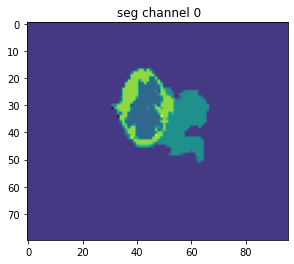

In [67]:
plt.title(f" seg channel {i}")
plt.imshow(seg[:, :, 20])
plt.show()

In [45]:
results.shape

torch.Size([4, 3, 80, 96, 64])

In [51]:
data1.shape

torch.Size([4, 4, 80, 96, 64])

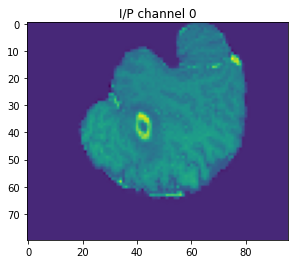

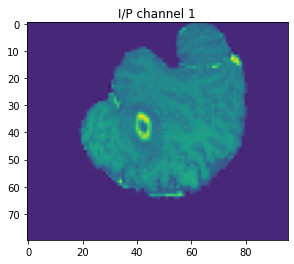

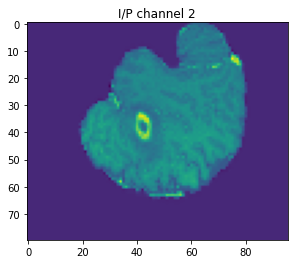

In [53]:
for i in range(3):
    plt.title(f"I/P channel {i}")
    plt.imshow(data1[0, i, :, :, 20].detach().cpu())
    plt.show()

In [41]:
# img2=(read_img(seg)[100]).astype(np.uint8)
# r = Image.fromarray(img2)
# r.putpalette([
#     0, 0, 0, # black background
#     255, 0, 0, # index 1 is red
#     255, 255, 0, # index 2 is yellow
#     255, 153, 0, # index 3 is orange
#     200,200,200, # index 4
# ])
# r

TypeError: ignored

In [84]:
np.unique(results[0,0,:,:,20].detach().cpu())

array([-9.862163e+00, -9.861345e+00, -9.851069e+00, -9.833146e+00, ..., -1.247633e-02, -1.213732e-02, -7.978112e-03,
        1.000000e+00], dtype=float32)

In [82]:
np1=results[0,0,:,:,20].detach().cpu() # 0,1 - 2nd class will get

In [83]:
np1[np1 > 0 ] = 1  

In [85]:
np1[np1 < 0] = 0

In [86]:
np.unique(np1)

array([0., 1.], dtype=float32)

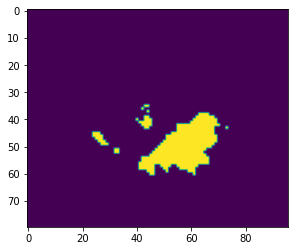

In [87]:
plt.imshow(np1)

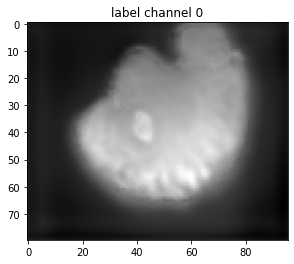

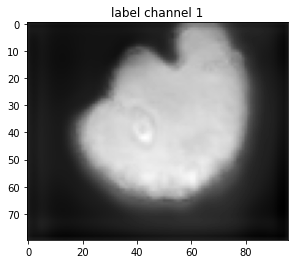

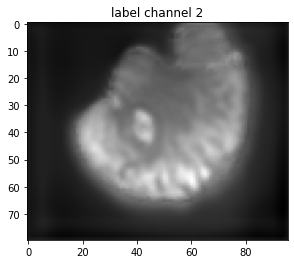

In [37]:
# outp = model(inp)
for i in range(3):
    plt.title(f"label channel {i}")
    plt.imshow(results[0, i, :, :, 20].detach().cpu(),cmap='gray')
    plt.show()

# DISCARD

In [71]:
#
results.shape

torch.Size([4, 3, 80, 96, 64])

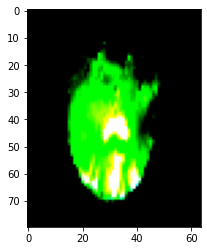

In [101]:
rs1=results[2, :, :, 50]#.numpy()
# print(results[0].shape)
# print(rs1.shape)
rs1=rs1.permute(1,2,0)
ts=rs1.detach().numpy()
plt.imshow(ts)

In [102]:
def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 155, 240, 240), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii.gz')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii.gz')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii.gz')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii.gz')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii.gz')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii.gz')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image

In [104]:
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

In [105]:
np_img = read_image_into_numpy('/content/gdrive/MyDrive/Clara/Clara_project/DatasetBR18/validation/MICCAI_BraTS_2018_Data_Validation/Brats18_CBICA_AAM_1')

In [112]:
from object_detection.utils import visualization_utils as vu


In [1]:
np_img

NameError: ignored

In [113]:
vu.show_n_images(np_img[:,100,:,:], titles=img_type)


AttributeError: ignored

In [69]:
testing=results[1].detach().numpy()


In [70]:
testing.shape

(3, 80, 96, 64)

In [ ]:
results1=results[1, :, :, 50]#.numpy()
results1=results1.permute(1,2,0)
results1=results1.detach().numpy()
results1.shape

import matplotlib.pyplot as plt
plt.imshow(results1,cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
#

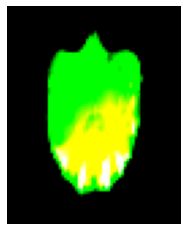

In [55]:
results1=results[1, :, :, 50]#.numpy()
results1=results1.permute(1,2,0)
results1=results1.detach().numpy()
results1.shape

import matplotlib.pyplot as plt
plt.imshow(results1,cmap="gray")
plt.axis("off")
plt.show()

In [26]:
prediction = F.softmax(torch.from_numpy(results1), dim=0).argmax(0).cpu().numpy()

In [ ]:
def forward(self, x: Tensor) -> Tensor:
    features = self.features(x)
    out = F.relu(features, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.class_layers(out)
    return out